<a href="https://colab.research.google.com/github/nehasharmn/Hybrid_CNN_Transformer_CHBMIT/blob/main/cnn%2Btransformer_chbmit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Required EEG and Deep Learning Libraries
This block installs MNE for EEG processing, Braindecode for EEG deep learning utilities, and PyTorch for model training.


In [ ]:
!pip install mne braindecode torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 146.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


###  Mount Google Drive and Set Data Directory
Mounts Google Drive so the notebook can load EDF files from the CHB-MIT dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/chbmit_data"
print("Using:", DATA_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: /content/drive/MyDrive/chbmit_data


### Required Summary Files for Seizure Labels
Defines which CHB-MIT summary text files must be present for seizure extraction


In [ ]:
import os

required = [
    "RECORDS-WITH-SEIZURES",
    "chb01-summary.txt",
    "chb02-summary.txt",
    "chb03-summary.txt",
    "chb13-summary.txt",
    "chb20-summary.txt"
]

print("Checking summary files...")
for f in required:
    path = os.path.join(DATA_ROOT, f)
    print(f"{f}:", "OK" if os.path.exists(path) else "MISSING")


Checking summary files...
RECORDS-WITH-SEIZURES: OK
chb01-summary.txt: OK
chb02-summary.txt: OK
chb03-summary.txt: OK
chb13-summary.txt: OK
chb20-summary.txt: OK


###  Parse CHB-MIT Summary Files to Extract Seizure Intervals
This function reads .txt summary files and extracts seizure start and end timestamps for each EDF recording


In [ ]:
def parse_summary_file(path):
    events = {}
    current_file = None
    start = None

    with open(path, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith("File Name:"):
                current_file = line.split(":")[1].strip().lower()
                events[current_file] = []
                continue

            if "Start Time" in line and "Seizure" in line:
                start = float(
                    line.split(":")[1].replace("seconds", "").strip()
                )
                continue

            if "End Time" in line and "Seizure" in line:
                end = float(
                    line.split(":")[1].replace("seconds", "").strip()
                )
                events[current_file].append((start, end))
                continue

    return events

SUMMARY = {
    "chb01": parse_summary_file(os.path.join(DATA_ROOT, "chb01-summary.txt")),
    "chb02": parse_summary_file(os.path.join(DATA_ROOT, "chb02-summary.txt")),
    "chb03": parse_summary_file(os.path.join(DATA_ROOT, "chb03-summary.txt")),
    "chb13": parse_summary_file(os.path.join(DATA_ROOT, "chb13-summary.txt")),
    "chb20": parse_summary_file(os.path.join(DATA_ROOT, "chb20-summary.txt")),
}

def load_seizure_intervals(patient, edf_filename):
    return SUMMARY.get(patient, {}).get(edf_filename.lower(), [])

### Load EDF Files and Normalize to a Fixed 23-Channels
Different EDF recordings have different channel sets. This block maps them into a consistent channel order or fills missing channels with zeros.


In [ ]:
import mne
import numpy as np

CHB_CHANNELS = [
    "FP1-F7","F7-T7","T7-P7","P7-O1",
    "FP1-F3","F3-C3","C3-P3","P3-O1",
    "FP2-F4","F4-C4","C4-P4","P4-O2",
    "FP2-F8","F8-T8","T8-P8","P8-O2",
    "FZ-CZ","CZ-PZ","P7-T7",
    "T7-FT9","FT9-FT10","FT10-T8","T8-P8"
]

def load_raw_fixed_channels(edf_path):
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    current = [ch.lower() for ch in raw.ch_names]

    data_list = []
    for ch in CHB_CHANNELS:
        name = ch.lower()
        if name in current:
            idx = current.index(name)
            data_list.append(raw.get_data(picks=[idx]))
        else:
            data_list.append(np.zeros((1, raw.n_times)))

    return np.vstack(data_list), raw.info["sfreq"]


### Extract Overlapping Windows With Balanced Seizure/Non-Seizure Sampling
This block slices EEG into fixed length windows, associates each with seizure labels, and down samples non-seizure windows to reduce class imbalance.


In [ ]:
def extract_windows_balanced(
    edf_path, patient,
    window_size=4.0,
    stride=0.5,
    non_seizure_fraction=0.01
):
    data, sfreq = load_raw_fixed_channels(edf_path)
    data = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-6)
    n_samples = data.shape[1]

    intervals = load_seizure_intervals(patient, os.path.basename(edf_path))
    seizure_segments = [(int(s * sfreq), int(e * sfreq)) for s, e in intervals]

    win_len = int(window_size * sfreq)
    step = int(stride * sfreq)

    seizure_X, seizure_y = [], []
    non_X, non_y = [], []

    for start in range(0, n_samples - win_len, step):
        end = start + win_len
        seg = data[:, start:end]

        is_seizure = any(not (end < s_start or start > s_end)
                         for s_start, s_end in seizure_segments)

        if is_seizure:
            seizure_X.append(seg)
            seizure_y.append(1)
        else:
            non_X.append(seg)
            non_y.append(0)

    if len(non_X) > 0:
        keep = int(len(non_X) * non_seizure_fraction)
        idx = np.random.choice(len(non_X), keep, replace=False)
        non_X = np.array(non_X)[idx]
        non_y = np.array(non_y)[idx]
    else:
        non_X = np.array([])
        non_y = np.array([])

    if len(seizure_X) > 0:
        seizure_X = np.array(seizure_X)
        seizure_y = np.array(seizure_y)

        X = np.concatenate([seizure_X, non_X], axis=0)
        y = np.concatenate([seizure_y, non_y], axis=0)
    else:
        X = non_X
        y = non_y

    return X, y


###  Build Training and Validation Sets From  EDF Files
Windows from selected patients are concatenated into training and validation datasets.


In [ ]:
train_patients = {"chb01", "chb02", "chb03", "chb13"}
val_patient = "chb20"

train_X, train_y = [], []
val_X, val_y = [], []

for edf in sorted(os.listdir(DATA_ROOT)):
    if not edf.endswith(".edf"):
        continue

    patient = edf[:5].lower()
    path = os.path.join(DATA_ROOT, edf)

    X, y = extract_windows_balanced(path, patient, window_size= 2)

    if patient in train_patients:
        train_X.append(X)
        train_y.append(y)
    elif patient == val_patient:
        val_X.append(X)
        val_y.append(y)

train_X = np.vstack(train_X)
train_y = np.hstack(train_y)

val_X = np.vstack(val_X)
val_y = np.hstack(val_y)

print("Train:", train_X.shape, np.unique(train_y, return_counts=True))
print("Val:", val_X.shape, np.unique(val_y, return_counts=True))


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8

Train: (9041, 23, 512) (array([0, 1]), array([5794, 3247]))
Val: (1020, 23, 512) (array([0, 1]), array([392, 628]))


### Analyze Class Imbalance in Validation Set
Shows how many windows contain seizures vs. non-seizures.


In [ ]:
import numpy as np

total = len(val_y)
seizures = np.sum(val_y == 1)
non_seizures = np.sum(val_y == 0)

print("Total val windows:", total)
print("Seizure windows:", seizures)
print("Non-seizure windows:", non_seizures)
print("Percent seizure: {:.4f}%".format(100 * seizures / total))


Total val windows: 1020
Seizure windows: 628
Non-seizure windows: 392
Percent seizure: 61.5686%


### Analyze Class Imbalance in Training Set
Shows how many windows contain seizures vs. non-seizures.


In [ ]:
import numpy as np

total = len(train_y)
seizures = np.sum(train_y == 1)
non_seizures = np.sum(train_y == 0)

print("Total train windows:", total)
print("Seizure windows:", seizures)
print("Non-seizure windows:", non_seizures)
print("Percent seizure: {:.4f}%".format(100 * seizures / total))


Total train windows: 9041
Seizure windows: 3247
Non-seizure windows: 5794
Percent seizure: 35.9142%


### Tiny EEG Transformer Architecture
A hybrid CNN + Transformer model that extracts spatial-temporal EEG features for seizure detection.


In [ ]:
import torch
import torch.nn as nn
from einops import rearrange

class EEGTransformer(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, num_layers=2):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(23, embed_dim, kernel_size=7, stride=4, padding=3),
            nn.ReLU(),
            nn.Conv1d(embed_dim, embed_dim, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            dim_feedforward=embed_dim * 4,
            dropout=0.1
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)

        self.cls = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.conv(x)
        x = rearrange(x, "b c t -> b t c")
        x = self.ln(x)
        x = self.transformer(x)
        self.dropout = nn.Dropout(0.3)
        x = self.dropout(x[:, -1, :])
        logit = self.cls(x).squeeze(1)
        return logit


### Define Training and Eval Functions
Implements the model training loop, validation loop, and uses BCEWithLogitsLoss with class weighting to handle imbalance.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.tensor(X, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)

      self.X = (self.X - self.X.mean(dim=-1, keepdim=True)) / \
         (self.X.std(dim=-1, keepdim=True) + 1e-6)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]




train_loader = DataLoader(
    EEGDataset(train_X, train_y),
    batch_size=64,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    EEGDataset(val_X, val_y),
    batch_size=64,
    shuffle=False
)


### Train EEG Transformer on Seizure Windows
Runs full training for 30 epochs and reports training and validation accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"
model = EEGTransformer().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([20.0]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_epoch(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            running_loss += loss.item() * X.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total


EPOCHS = 30
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")


Epoch 01 | Train Loss 2.0194 Acc 0.4242 | Val Loss 2.1991 Acc 0.6176
Epoch 02 | Train Loss 1.0983 Acc 0.7241 | Val Loss 9.0303 Acc 0.6324
Epoch 03 | Train Loss 0.6711 Acc 0.8551 | Val Loss 8.0395 Acc 0.6343
Epoch 04 | Train Loss 0.5714 Acc 0.8650 | Val Loss 23.6327 Acc 0.5794
Epoch 05 | Train Loss 0.4574 Acc 0.9036 | Val Loss 28.0510 Acc 0.5520
Epoch 06 | Train Loss 0.3733 Acc 0.9192 | Val Loss 23.2795 Acc 0.5941
Epoch 07 | Train Loss 0.3601 Acc 0.9234 | Val Loss 5.5160 Acc 0.6696
Epoch 08 | Train Loss 0.2875 Acc 0.9413 | Val Loss 46.9701 Acc 0.4892
Epoch 09 | Train Loss 0.3780 Acc 0.9130 | Val Loss 41.7455 Acc 0.4961
Epoch 10 | Train Loss 0.2497 Acc 0.9456 | Val Loss 39.0905 Acc 0.5245
Epoch 11 | Train Loss 0.2396 Acc 0.9449 | Val Loss 35.3284 Acc 0.5657
Epoch 12 | Train Loss 0.4301 Acc 0.8997 | Val Loss 14.1479 Acc 0.6078
Epoch 13 | Train Loss 0.2900 Acc 0.9394 | Val Loss 13.0163 Acc 0.6431
Epoch 14 | Train Loss 0.1786 Acc 0.9598 | Val Loss 40.5775 Acc 0.5765
Epoch 15 | Train Loss 0.

In [ ]:
save_path = "/content/drive/MyDrive/chbmit_data/eeg_transformer_model.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, save_path)

print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/chbmit_data/eeg_transformer_model.pth


### Compute Seizure Detection Metrics
Evaluates sensitivity, precision, and confusion statistics using probability thresholds


In [ ]:
def evaluate_seizure_detection(model, loader):
    model.eval()
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.3).astype(int)
            preds_all.extend(preds)
            labels_all.extend(y.cpu().numpy())

    preds_all = np.array(preds_all)
    labels_all = np.array(labels_all)


    tp = np.sum((preds_all == 1) & (labels_all == 1))
    fp = np.sum((preds_all == 1) & (labels_all == 0))
    fn = np.sum((preds_all == 0) & (labels_all == 1))

    sensitivity = tp / (tp + fn + 1e-8)
    precision   = tp / (tp + fp + 1e-8)

    print("TP:", tp)
    print("FP:", fp)
    print("FN:", fn)
    print("Sensitivity (Recall):", sensitivity)
    print("Precision:", precision)


In [ ]:
print("\n=== SEIZURE DETECTION METRICS ===")
evaluate_seizure_detection(model, val_loader)



=== SEIZURE DETECTION METRICS ===
TP: 154
FP: 36
FN: 474
Sensitivity (Recall): 0.2452229299324009
Precision: 0.8105263157468143


In [ ]:
model = EEGTransformer().to(device)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total Parameters:", count_params(model))


Total Parameters: 139265


### Benchmark Inference Latency, Throughput, and Accuracy
Measures how fast the model runs on GPU/CPU and how many samples per second it can process.


In [ ]:
def benchmark_model(model, val_loader):
    import time
    model.eval()

    latencies = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            start = time.time()
            _ = model(X)
            end = time.time()
            latencies.append(end - start)
    avg_latency = np.mean(latencies)

    throughput = len(val_loader.dataset) / sum(latencies)

    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds == y).sum().item()
            total += y.size(0)
    accuracy = correct / total

    return {
        "latency": avg_latency,
        "throughput": throughput,
        "accuracy": accuracy
    }


### Compare Window Sizes (1s, 2s, 4s) on Performance
Retrains the model using various window lengths and evaluates accuracy, latency, and performance.


In [ ]:


window_sizes = [1, 2, 4]

results = {}

for win in window_sizes:

    print(f"Training model with window size = {win} sec")


    train_X, train_y = [], []
    val_X, val_y = [], []

    for edf in sorted(os.listdir(DATA_ROOT)):
        if not edf.endswith(".edf"):
            continue

        patient = edf[:5].lower()
        path = os.path.join(DATA_ROOT, edf)

        X, y = extract_windows_balanced(path, patient, window_size=win)

        if patient in train_patients:
            train_X.append(X)
            train_y.append(y)
        elif patient == val_patient:
            val_X.append(X)
            val_y.append(y)


    train_X = np.vstack(train_X)
    train_y = np.hstack(train_y)
    val_X = np.vstack(val_X)
    val_y = np.hstack(val_y)


    train_loader = DataLoader(EEGDataset(train_X, train_y), batch_size=64, shuffle=True)
    val_loader   = DataLoader(EEGDataset(val_X, val_y), batch_size=64, shuffle=False)


    model = EEGTransformer().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(device))


    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        print(f"Epoch {epoch+1} | Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}")



    print("\nEvaluating seizure performance...")
    evaluate_seizure_detection(model, val_loader)


    bench = benchmark_model(model, val_loader)


    results[win] = {
        "model": model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "latency": bench["latency"],
        "throughput": bench["throughput"],
        "benchmark_accuracy": bench["accuracy"]
    }

    print(f"\n--- Benchmark for {win}-sec model ---")
    print(f"Latency: {bench['latency']:.6f}s")
    print(f"Throughput: {bench['throughput']:.2f} samples/sec")
    print(f"Accuracy: {bench['accuracy']:.3f}")


Training model with window size = 1 sec


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8

Epoch 1 | Train Acc 0.586 | Val Acc 0.604
Epoch 2 | Train Acc 0.835 | Val Acc 0.577
Epoch 3 | Train Acc 0.897 | Val Acc 0.627
Epoch 4 | Train Acc 0.924 | Val Acc 0.590
Epoch 5 | Train Acc 0.929 | Val Acc 0.617
Epoch 6 | Train Acc 0.941 | Val Acc 0.499
Epoch 7 | Train Acc 0.949 | Val Acc 0.582
Epoch 8 | Train Acc 0.945 | Val Acc 0.593
Epoch 9 | Train Acc 0.955 | Val Acc 0.467
Epoch 10 | Train Acc 0.965 | Val Acc 0.494

Evaluating seizure performance...
TP: 167
FP: 43
FN: 445
Sensitivity (Recall): 0.2728758169890053
Precision: 0.7952380952002267

--- Benchmark for 1-sec model ---
Latency: 0.001044s
Throughput: 60086.20 samples/sec
Accuracy: 0.482
Training model with window size = 2 sec


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8

Epoch 1 | Train Acc 0.588 | Val Acc 0.591
Epoch 2 | Train Acc 0.896 | Val Acc 0.540
Epoch 3 | Train Acc 0.902 | Val Acc 0.603
Epoch 4 | Train Acc 0.940 | Val Acc 0.531
Epoch 5 | Train Acc 0.950 | Val Acc 0.610
Epoch 6 | Train Acc 0.962 | Val Acc 0.467
Epoch 7 | Train Acc 0.963 | Val Acc 0.447
Epoch 8 | Train Acc 0.964 | Val Acc 0.410
Epoch 9 | Train Acc 0.961 | Val Acc 0.470
Epoch 10 | Train Acc 0.975 | Val Acc 0.464

Evaluating seizure performance...
TP: 121
FP: 25
FN: 507
Sensitivity (Recall): 0.1926751592326007
Precision: 0.8287671232309063

--- Benchmark for 2-sec model ---
Latency: 0.001058s
Throughput: 60234.99 samples/sec
Accuracy: 0.462
Training model with window size = 4 sec


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8

Epoch 1 | Train Acc 0.583 | Val Acc 0.471
Epoch 2 | Train Acc 0.914 | Val Acc 0.419
Epoch 3 | Train Acc 0.947 | Val Acc 0.494
Epoch 4 | Train Acc 0.964 | Val Acc 0.531
Epoch 5 | Train Acc 0.973 | Val Acc 0.395
Epoch 6 | Train Acc 0.975 | Val Acc 0.413
Epoch 7 | Train Acc 0.973 | Val Acc 0.503
Epoch 8 | Train Acc 0.981 | Val Acc 0.395
Epoch 9 | Train Acc 0.982 | Val Acc 0.429
Epoch 10 | Train Acc 0.976 | Val Acc 0.419

Evaluating seizure performance...
TP: 58
FP: 2
FN: 602
Sensitivity (Recall): 0.08787878787745639
Precision: 0.9666666665055555

--- Benchmark for 4-sec model ---
Latency: 0.001017s
Throughput: 60866.67 samples/sec
Accuracy: 0.417


In [ ]:
import pandas as pd

df = pd.DataFrame(results).T
df


,model,train_acc,val_acc,latency,throughput,benchmark_accuracy
1,EEGTransformer(\n (conv): Sequential(\n (0...,0.965387,0.494024,0.001044,60086.199646,0.482072
2,EEGTransformer(\n (conv): Sequential(\n (0...,0.974671,0.463725,0.001058,60234.988807,0.461765
4,EEGTransformer(\n (conv): Sequential(\n (0...,0.976292,0.419202,0.001017,60866.674134,0.4173


In [ ]:
import numpy as np
import torch
import time

class RealTimeEEGDetector:
    def __init__(self, model, sfreq, window_size=2.0, stride=0.5, device="cpu"):
        self.model = model.to(device)
        self.sfreq = sfreq
        self.window_size = int(window_size * sfreq)
        self.stride = int(stride * sfreq)
        self.device = device

        self.buffer = None
        self.next_eval_idx = self.window_size

    def add_samples(self, samples):
        if self.buffer is None:
            self.buffer = samples
        else:
            self.buffer = np.concatenate([self.buffer, samples], axis=1)

    def is_ready(self):
        return (
            self.buffer is not None and
            self.buffer.shape[1] >= self.next_eval_idx
        )

    def run_inference(self):
        start_idx = self.next_eval_idx - self.window_size
        end_idx = self.next_eval_idx

        window = self.buffer[:, start_idx:end_idx]

        window = (window - window.mean(axis=1, keepdims=True)) / \
                 (window.std(axis=1, keepdims=True) + 1e-6)

        X = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits = self.model(X)
            prob = torch.sigmoid(logits).item()

        self.next_eval_idx += self.stride

        return prob


Using EDF: /content/drive/MyDrive/chbmit_data/chb01_03.edf


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Streaming EEG in real-time...

Seizure probability: 0.0006
Seizure probability: 0.0010
Seizure probability: 0.0002
Seizure probability: 0.0005
Seizure probability: 0.0006
Seizure probability: 0.0022
Seizure probability: 0.0028
Seizure probability: 0.0005
Seizure probability: 0.0081
Seizure probability: 0.0006
Seizure probability: 0.0014
Seizure probability: 0.0007
Seizure probability: 0.0002
Seizure probability: 0.0009
Seizure probability: 0.0007
Seizure probability: 0.0001
Seizure probability: 0.0001
Seizure probability: 0.0002
Seizure probability: 0.0005
Seizure probability: 0.0005
Seizure probability: 0.0015
Seizure probability: 0.0017
Seizure probability: 0.0004
Seizure probability: 0.0005
Seizure probability: 0.0014
Seizure probability: 0.0012
Seizure probability: 0.0011
Seizure probability: 0.7228
Seizure probability: 0.9986
Seizure probability: 0.9971
Seizure probability: 0.0409
Seizure probability: 0.0182
Seizure probability: 0.0008
Seizure probability: 0.0004
Seizure probabili

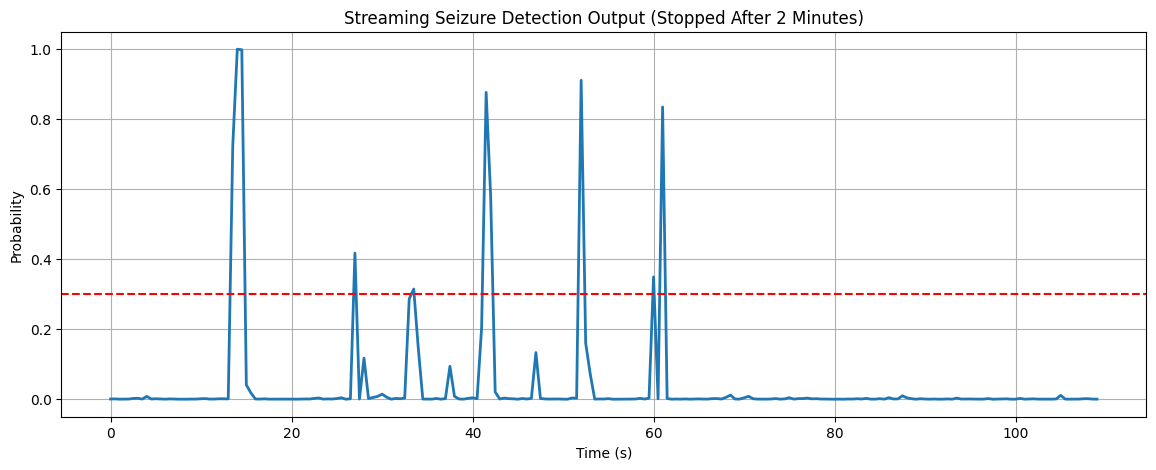

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

example_edf = sorted([f for f in os.listdir(DATA_ROOT) if f.endswith(".edf")])[0]
edf_path = os.path.join(DATA_ROOT, example_edf)
print("Using EDF:", edf_path)

data, sfreq = load_raw_fixed_channels(edf_path)

detector = RealTimeEEGDetector(
    model=model,
    sfreq=sfreq,
    window_size=2.0,
    stride=0.5,
    device=device
)

chunk_ms = 50
chunk_samples = int((chunk_ms / 1000) * sfreq)

cursor = 0

probs = []
times = []
current_t = 0.0

max_runtime = 120
start_time = time.time()

print("Streaming EEG in real-time...\n")

while cursor < data.shape[1] and (time.time() - start_time) < max_runtime:

    end = min(cursor + chunk_samples, data.shape[1])
    detector.add_samples(data[:, cursor:end])
    cursor = end

    if detector.is_ready():
        prob = detector.run_inference()
        print(f"Seizure probability: {prob:.4f}")

        probs.append(prob)
        times.append(current_t)
        current_t += 0.5

    time.sleep(chunk_ms / 1000.0)

print("\nStopped streaming after 2 minutes.")

plt.figure(figsize=(14, 5))
plt.plot(times, probs, linewidth=2)
plt.axhline(0.3, color='red', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.title("Streaming Seizure Detection Output (Stopped After 2 Minutes)")
plt.grid(True)
plt.show()


In [ ]:
SEIZURE_THRESHOLD = 0.3

if prob > SEIZURE_THRESHOLD:
    print("⚡ SEIZURE DETECTED")
else:
    print("OK")


OK


In [ ]:
start = time.time()
prob = detector.run_inference()
latency = (time.time() - start) * 1000
print("Inference latency (ms):", latency)


Inference latency (ms): 6.2713623046875
